In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
from pickle import dump, load
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.layers import Dense, Activation
from keras.models import Sequential
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

from traj_gen import gen_traj

from tqdm import tnrange, tqdm_notebook

In [37]:
street = imread('street.png')

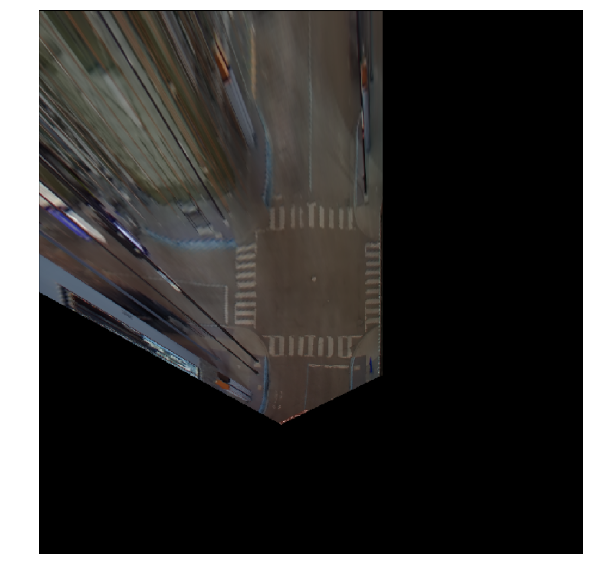

In [113]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(street)
plt.show()

In [2]:
# load data
with open('data/all_trajs_zeroed.p', 'r') as f:
    all_trajs_zeroed = load(f)
    
with open('data/all_trajs_raw.p', 'r') as f:
    all_trajs_raw = load(f)

with open('data/train_test_ids.p', 'r') as f:
    train_test_ids = load(f)
    
with open('data/use_sets.p', 'r') as f:
    use_set = load(f)

In [3]:
# processing data into autoregression chunks
use_trajs = all_trajs_raw
train_trajs = np.take(use_trajs[7], train_test_ids[7]['train'], axis=0)    
test_trajs = np.take(use_trajs[7], train_test_ids[7]['test'], axis=0)

In [64]:
T_i = 10
T_o = 10
subsample = 3
X_tr, Y_tr, X_t, Y_t = [], [], [], []

In [65]:
for j, train_traj in enumerate(train_trajs):
    if j not in use_set['train']:
        continue
    for k in range(subsample):
        inds = np.arange(k, len(train_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_tr.append(np.take(train_traj, inds[i:i+T_i], axis=0).flatten())
            Y_tr.append(np.take(train_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_tr = np.array(X_tr)
Y_tr = np.array(Y_tr)

In [66]:
for j, test_traj in enumerate(test_trajs):
    if j not in use_set['train']:
        continue
    for k in range(subsample):
        inds = np.arange(k, len(test_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_t.append(np.take(test_traj, inds[i:i+T_i], axis=0).flatten())
            Y_t.append(np.take(test_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_t = np.array(X_t)
Y_t = np.array(Y_t)

### 3: Linear model

In [67]:
# linear regression on T-step zeroed trajs for cars
lin = LinearRegression(n_jobs=4)
lin.fit(X_tr, Y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [68]:
lin.score(X_t, Y_t)

0.95971009179869371

### 4: NN Model

In [69]:
nn= Sequential()
nn.add(Dense(input_dim=2 * T_i, units=100, activation='relu'))
nn.add(Dense(input_dim=100, units=50, activation='relu'))
nn.add(Dense(input_dim=50, units=2 * T_o, activation='linear'))
nn.compile(loss='mse', optimizer='adam', metrics=['mape'])

In [70]:
nn.fit(X_tr, Y_tr, batch_size=64, epochs=20, verbose=0, validation_split=0.2, callbacks=[TQDMNotebookCallback()])

### 5: RF Model

In [71]:
rf = RandomForestRegressor()

In [72]:
rf.fit(X_tr, Y_tr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [91]:
def eval_model(name, model, X_tr, Y_tr, X_t, Y_t, T_o):
    Y_tr_pred = model.predict(X_tr)
    Y_t_pred = model.predict(X_t)
    
    mae_tr = mean_absolute_error(Y_tr, Y_tr_pred) / (T_o * 2)
    mae_t = mean_absolute_error(Y_t, Y_t_pred) / (T_o * 2)
    
    mse_tr = mean_squared_error(Y_tr, Y_tr_pred)
    mse_t = mean_squared_error(Y_t, Y_t_pred)
    
    r2_tr = r2_score(Y_tr, Y_tr_pred)
    r2_t = r2_score(Y_t, Y_t_pred)
    
    print name
    print 'Tr: MAPxE {:.3f} | MSE {:.3f} | R2 {:.3f}'.format(mae_tr, mse_tr, r2_tr)
    print 'T: MAPxE {:.3f} | MSE {:.3f} | R2 {:.3f}'.format(mae_t, mse_t, r2_t)    

In [93]:
eval_model('Lin', lin, X_tr, Y_tr, X_t, Y_t, T_o)
eval_model('RF', rf, X_tr, Y_tr, X_t, Y_t, T_o)
eval_model('NN', nn, X_tr, Y_tr, X_t, Y_t, T_o)

/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


Lin
Tr: MAPxE 0.684 | MSE 767.332 | R2 0.963
T: MAPxE 0.757 | MSE 859.621 | R2 0.960
RF

/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)



Tr: MAPxE 0.124 | MSE 39.998 | R2 0.998
T: MAPxE 0.883 | MSE 952.707 | R2 0.955
NN
Tr: MAPxE 0.743 | MSE 681.394 | R2 0.967
T: MAPxE 0.764 | MSE 793.568 | R2 0.963


/home/jacky/env/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


In [85]:
print X_tr.shape, X_t.shape

(34234, 20) (8305, 20)


In [106]:
len(use_set['train']), len(use_set['test'])

(365, 117)

### Generating new trajs

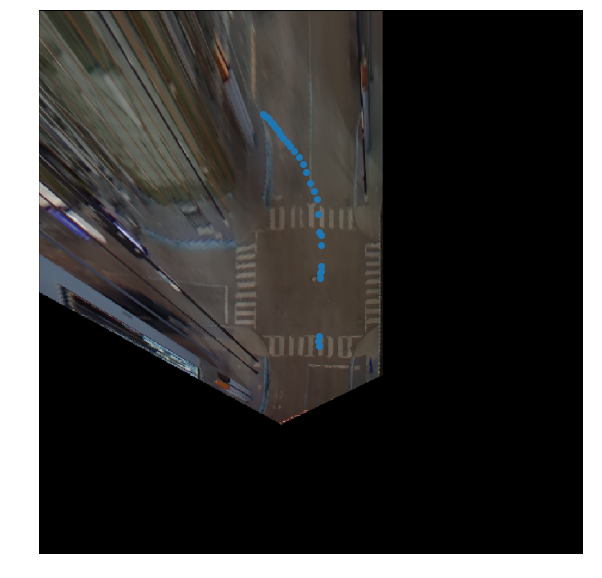

In [128]:
n = 1
T = 20
traj_pred = gen_traj(nn, use_trajs[7][n][0:T_i*subsample:subsample].reshape(1,-1), T_i, T_o, T)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(street)
plt.scatter(traj_pred[:,0], traj_pred[:,1])
plt.show()

In [146]:
def save_trajs(name, model, seeds, T):
    plt.figure(figsize=(10,10))
    trajs = []
    for i in tqdm_notebook(range(len(seeds))):
        if i in use_set['train'] or i in use_set['test']:
            plt.clf()
            plt.axis('off')
            seed = seeds[i]
            try:
                traj_pred = gen_traj(model, seed[:T_i*subsample:subsample].reshape(1,-1), T_i, T_o, T)
            except:
                continue
            plt.imshow(street)
            plt.scatter(traj_pred[:,0], traj_pred[:,1])
            plt.savefig('ims/{}_gens/{}.png'.format(name, i))
            trajs.append(traj_pred)
    return trajs

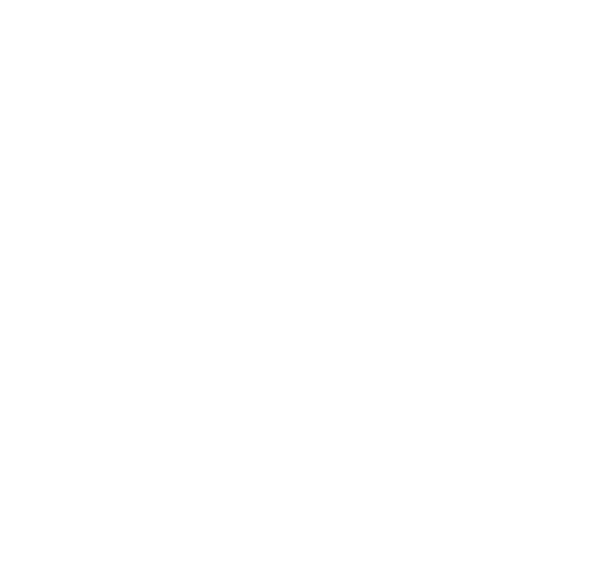

In [147]:
T = 30
nn_trajs = save_trajs('nn', nn, use_trajs[7], T)

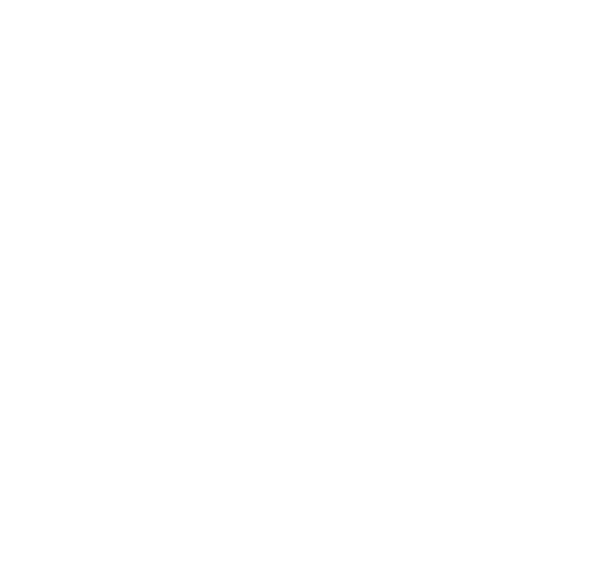

In [148]:
lin_trajs = save_trajs('lin', lin, use_trajs[7], T)

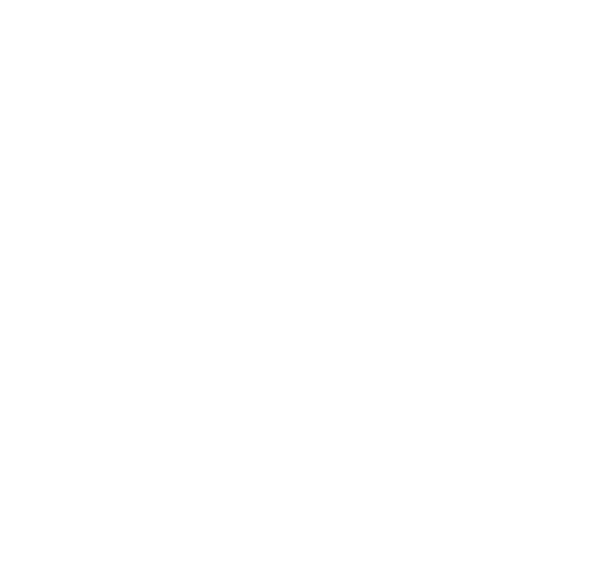

In [149]:
rf_trajs = save_trajs('rf', rf, use_trajs[7], T)

In [151]:
with open('data/gen_trajs.p', 'w') as f:
    dump({
            'nn': nn_trajs,
            'lin': lin_trajs,
            'rf': rf_trajs
        }, f)